# Udacity Deep Learning Project - Digit Recognition - Part 3 - Digit Recognizer Evaluation

Author: Lei Mao <br>
Late revised on: 2/10/2016 <br>

### Import libraries required

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import cv2
from six.moves import cPickle as pickle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
%autosave 0

Autosave disabled


### Preprocess test dataset

In [3]:
# Read test dataset
SVHN_folder = 'data/SVHN/'
pickle_file = 'test_set.pickle'

with open(SVHN_folder + pickle_file, 'rb') as f:
    print('Loading data ...')
    print('This may consume a lot of memories.')
    save = pickle.load(f)
    SVHN_test_dataset = save['dataset']
    SVHN_test_labels = save['labels']
    del save  # hint to help gc free up memory
    print('SVHN test set', SVHN_test_dataset.shape, SVHN_test_labels.shape)

Loading data ...
This may consume a lot of memories.
('SVHN test set', (13068, 32, 32, 3), (13068, 6))


In [4]:
# Split test dataset to test and validation datasets
SVHN_test_dataset, SVHN_valid_dataset, SVHN_test_labels, SVHN_valid_labels = train_test_split(
    SVHN_test_dataset, SVHN_test_labels, test_size = 5./10, random_state = 0)

In [5]:
# Cut the label
length_limit = 5
test_labels = SVHN_test_labels[:, 0: length_limit]

In [6]:
def image_grayed(dataset):
    dataset_grayed = np.zeros(shape = (dataset.shape[0], dataset.shape[1], dataset.shape[2], 1), dtype = np.int32)
    for i in xrange(len(dataset)):
        for j in xrange(dataset.shape[3]):
            dataset_grayed[i, :, :, 0] += dataset[i, :, :, j]
        dataset_grayed[i] = dataset_grayed[i] // dataset.shape[3]
        # Normalize each image by subtracting its mean
        dataset_grayed[i, :, :, 0] = dataset_grayed[i, :, :, 0] - np.mean(dataset_grayed[i, :, :, 0])
    return dataset_grayed.astype(np.uint8)

In [7]:
# Gray all the datasets
test_dataset = image_grayed(SVHN_test_dataset)

In [8]:
print('Test set: %d images and %d labels.' %(len(SVHN_test_dataset), len(SVHN_test_labels)))

Test set: 6534 images and 6534 labels.


### Restore model

In [9]:
batch_size = 64
patch_size = 3
depth_1 = 16
depth_2 = 32
depth_3 = 64

num_hidden = 64
num_channels = 1
keep_prob = 0.8

num_image_rows = SVHN_test_dataset.shape[1]
num_image_columns = SVHN_test_dataset.shape[2]
num_channels = 1

num_length_class = length_limit + 2 # 0, 1, 2, 3, 4, 5, more than 5
num_digit_class = 11 # 0: blank, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 0

graph = tf.Graph()

with graph.as_default():

    # Variables
    cnn_1_1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth_1], stddev=0.1), 
                                name = 'CNN_1_1_W')
    cnn_1_1_biases = tf.Variable(tf.zeros([depth_1]), name = 'CNN_1_1_B')

    cnn_1_2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth_1, depth_1], stddev=0.1), 
                                name = 'CNN_1_2_W')
    cnn_1_2_biases = tf.Variable(tf.zeros([depth_1]), name = 'CNN_1_2_B')    

    cnn_2_1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth_1, depth_2], stddev=0.1), 
                                name = 'CNN_2_1_W')
    cnn_2_1_biases = tf.Variable(tf.constant(1.0, shape=[depth_2]), name = 'CNN_2_1_B')

    cnn_2_2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth_2, depth_2], stddev=0.1), 
                                name = 'CNN_2_2_W')
    cnn_2_2_biases = tf.Variable(tf.constant(1.0, shape=[depth_2]), name = 'CNN_2_2_B')

    cnn_3_1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth_2, depth_3], stddev=0.1), 
                                name = 'CNN_3_1_W')
    cnn_3_1_biases = tf.Variable(tf.constant(1.0, shape=[depth_3]), name = 'CNN_3_1_B')

    cnn_3_2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth_3, depth_3], stddev=0.1), 
                                name = 'CNN_3_2_W')
    cnn_3_2_biases = tf.Variable(tf.constant(1.0, shape=[depth_3]), name = 'CNN_3_2_B')

    fc_1_weights = tf.Variable(tf.truncated_normal(
            [num_image_rows // 8 * num_image_columns // 8 * depth_3, num_hidden], stddev=0.1), name = 'FC_1_W')
    fc_1_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]), name = 'FC_1_B')
    
    logistic_weights = list()
    logistic_biases = list()
    logistic_weights.append(tf.Variable(tf.truncated_normal([num_hidden, num_length_class], stddev=0.1), name = 'H0_W'))
    logistic_biases.append(tf.Variable(tf.zeros([num_length_class]), name = 'H0_B'))
    
    for i in xrange(length_limit):
        logistic_weights.append(tf.Variable(
                tf.truncated_normal([num_hidden, num_digit_class], stddev=0.1), name = 'H' + str(i + 1) + '_W'))
        logistic_biases.append(tf.Variable(tf.constant(1.0, shape=[num_digit_class]), name = 'H' + str(i + 1) + '_B'))

    # Model
    def model(data, keep_prob = keep_prob):
        
        conv = tf.nn.conv2d(data, cnn_1_1_weights, [1, 1, 1, 1], padding = 'SAME')
        hidden = tf.nn.relu(conv + cnn_1_1_biases)
        conv = tf.nn.conv2d(hidden, cnn_1_2_weights, [1, 1, 1, 1], padding = 'SAME')
        hidden = tf.nn.relu(conv + cnn_1_2_biases)        
        # local_response_normalization is very useful in this case
        hidden = tf.nn.local_response_normalization(hidden)
        hidden = tf.nn.max_pool(hidden, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
        
        conv = tf.nn.conv2d(hidden, cnn_2_1_weights, [1, 1, 1, 1], padding = 'SAME')
        hidden = tf.nn.relu(conv + cnn_2_1_biases)
        conv = tf.nn.conv2d(hidden, cnn_2_2_weights, [1, 1, 1, 1], padding = 'SAME')
        hidden = tf.nn.relu(conv + cnn_2_2_biases)
        # local_response_normalization is very useful in this case
        hidden = tf.nn.local_response_normalization(hidden)
        hidden = tf.nn.max_pool(hidden, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

        conv = tf.nn.conv2d(hidden, cnn_3_1_weights, [1, 1, 1, 1], padding = 'SAME')
        hidden = tf.nn.relu(conv + cnn_3_1_biases)
        conv = tf.nn.conv2d(hidden, cnn_3_2_weights, [1, 1, 1, 1], padding = 'SAME')
        hidden = tf.nn.relu(conv + cnn_3_2_biases)
        # local_response_normalization is very useful in this case
        hidden = tf.nn.local_response_normalization(hidden)
        hidden = tf.nn.max_pool(hidden, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, fc_1_weights) + fc_1_biases)
        hidden = tf.nn.dropout(hidden, keep_prob = keep_prob)
        
        logits = list()
        for i in xrange(length_limit + 1):
            logits.append(tf.matmul(hidden, logistic_weights[i]) + logistic_biases[i])
        
        return logits

    # Prediction of single test data
    # Input data
    tf_test_single = tf.placeholder(tf.float32, shape=(1, num_image_rows, num_image_columns, num_channels))
    # Predict the length of sequence in single test data
    test_logits_single = model(tf_test_single, keep_prob = 1.0)
    test_prediction_length_single = tf.nn.softmax(test_logits_single[0])
    # Predict the digits of sequence in single test data
    test_prediction_digits_single = list()
    for i in xrange(length_limit):
        test_prediction_digits_single.append(tf.nn.softmax(test_logits_single[i + 1]))
    test_prediction_digits_single = tf.pack(test_prediction_digits_single)

    saver = tf.train.Saver()

### SVHN examples

In [10]:
# Choose 5 random examples from test dataset
np.random.seed(40)
num_examples = 5

In [11]:
model_path = 'model/'
dataset = test_dataset
index = np.random.randint(len(dataset), size = num_examples)
predicted_labels = list()

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    saver.restore(session, model_path + 'CNN_SVHN')
    for i in xrange(num_examples):
        img = dataset[[index[i]]]
        feed_dict = {tf_test_single: img}
        prediction_array = test_prediction_digits_single.eval(feed_dict = feed_dict)
        prediction_number = list()
        for j in xrange(len(prediction_array)):
            prediction_number.append(np.argmax(prediction_array[j]))
        predicted_labels.append(prediction_number)

In [12]:
def label_translation(label_array):
    translation_dict = {0: '', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '0'}
    label_translated = ''
    for i in xrange(len(label_array)):
        label_translated += translation_dict[label_array[i]]
    return label_translated

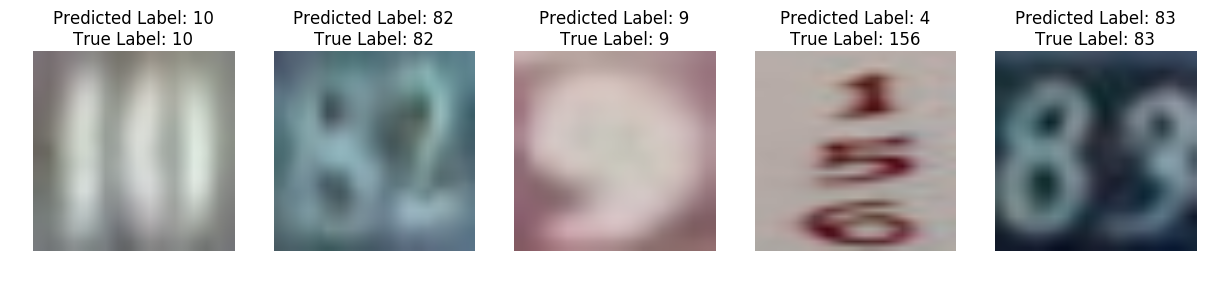

In [13]:
num_subplots = num_examples

fig, axes = plt.subplots(nrows = 1, ncols = num_examples, figsize = (15, 5))
for i in xrange(num_examples):
    axes[i].axis('off')
    axes[i].imshow(SVHN_test_dataset[index[i]])
    axes[i].set_title('Predicted Label: ' + label_translation(predicted_labels[i]) + '\n' + 'True Label: ' + label_translation(test_labels[index[i]]), loc='center')

report_folder = 'report/'
if not os.path.exists(report_folder):
    os.makedirs(report_folder)
fig.savefig(report_folder + 'SVHN_prediction.jpeg', format = 'jpeg', dpi = 300, bbox_inches = 'tight')

It seems that the digit recognizer works quite well on the SVHN dataset that I prepared. Now I am going to further apply some new images that I took from the real world to the digit recognizer. There might be some mistakes. But I think it is due to the low resolution of the image and some similar digits such as 1 and 7.

In [14]:
test_folder = 'test/real/'
file_names = os.listdir(test_folder)
real_dataset = np.zeros(shape = (len(file_names), num_image_rows, num_image_columns, 3), dtype = np.int)
for i, file_name in enumerate(file_names):
    img = cv2.imread(test_folder + file_name)
    img_resized = cv2.resize(img, (num_image_rows, num_image_columns))
    real_dataset[i] = img_resized

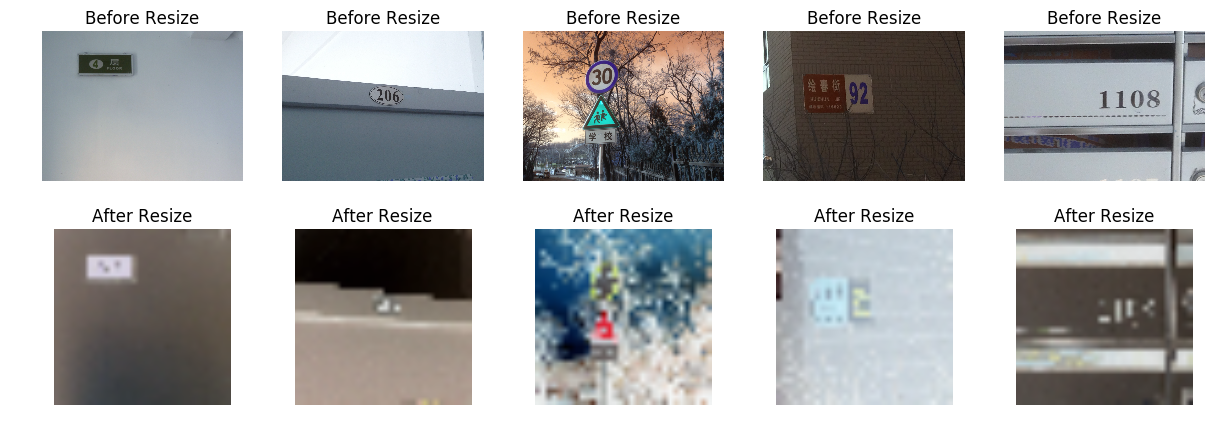

In [15]:
fig, axes = plt.subplots(nrows = 2, ncols = num_examples, figsize = (15, 5))
for i in xrange(num_examples):
    axes[0, i].axis('off')
    axes[0, i].imshow(cv2.imread(test_folder + file_names[i]))
    axes[0, i].set_title('Before Resize', loc='center')
    
    axes[1, i].axis('off')
    axes[1, i].imshow(real_dataset[i])
    axes[1, i].set_title('After Resize', loc='center')
    
report_folder = 'report/'
if not os.path.exists(report_folder):
    os.makedirs(report_folder)
fig.savefig(report_folder + 'real_image_samples.jpeg', format = 'jpeg', dpi = 300, bbox_inches = 'tight')

Because the raw images were very large, so after resizing to small images, the content quality drops significantly. There should be no way for the classifier to identify these digits. We will preprocess and run these images on the digit recognizer anyway.

In [16]:
# Gray all the datasets
real_dataset_grayed = image_grayed(real_dataset)

In [17]:
model_path = 'model/'
dataset = real_dataset_grayed
predicted_labels = list()

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    saver.restore(session, model_path + 'CNN_SVHN')
    for i in xrange(num_examples):
        img = dataset[[i]]
        feed_dict = {tf_test_single: img}
        prediction_array = test_prediction_digits_single.eval(feed_dict = feed_dict)
        prediction_number = list()
        for j in xrange(len(prediction_array)):
            prediction_number.append(np.argmax(prediction_array[j]))
        predicted_labels.append(prediction_number)

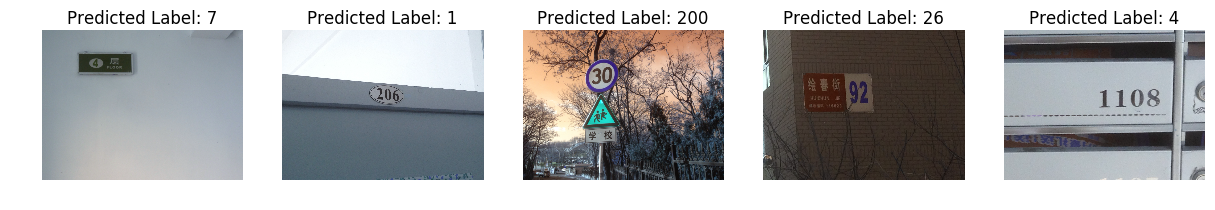

In [18]:
num_subplots = num_examples

fig, axes = plt.subplots(nrows = 1, ncols = num_examples, figsize = (15, 5))
for i in xrange(num_examples):
    axes[i].axis('off')
    axes[i].imshow(cv2.imread(test_folder + file_names[i]))
    axes[i].set_title('Predicted Label: ' + label_translation(predicted_labels[i]), loc='center')

report_folder = 'report/'
if not os.path.exists(report_folder):
    os.makedirs(report_folder)
fig.savefig(report_folder + 'real_image_prediction_no_manipulation.jpeg', format = 'jpeg', dpi = 300, bbox_inches = 'tight')

We can see that the predictions were extremely bad. However, if somehow we crop the digit sequence from the raw image and run them on the digit recognizer, the result will be much better. Here I will crop the digit sequence manually.

In [19]:
# These are the crop parameters I manually found
x1_crop = [90, 850, 120, 800, 850, 190, 150]
y1_crop = [130, 1200, 180, 1300, 1350, 250, 230]
x2_crop = [150, 1500, 220, 1350, 1500, 360, 210]
y2_crop = [200, 1900, 320, 1750, 2600, 420, 320]

In [20]:
real_dataset_cropped = np.zeros(shape = (len(file_names), num_image_rows, num_image_columns, 3), dtype = np.int)
for i, file_name in enumerate(file_names):
    img = cv2.imread(test_folder + file_name)[x1_crop[i]:y1_crop[i], x2_crop[i]:y2_crop[i]]
    img_resized = cv2.resize(img, (num_image_rows, num_image_columns))
    real_dataset_cropped[i] = img_resized

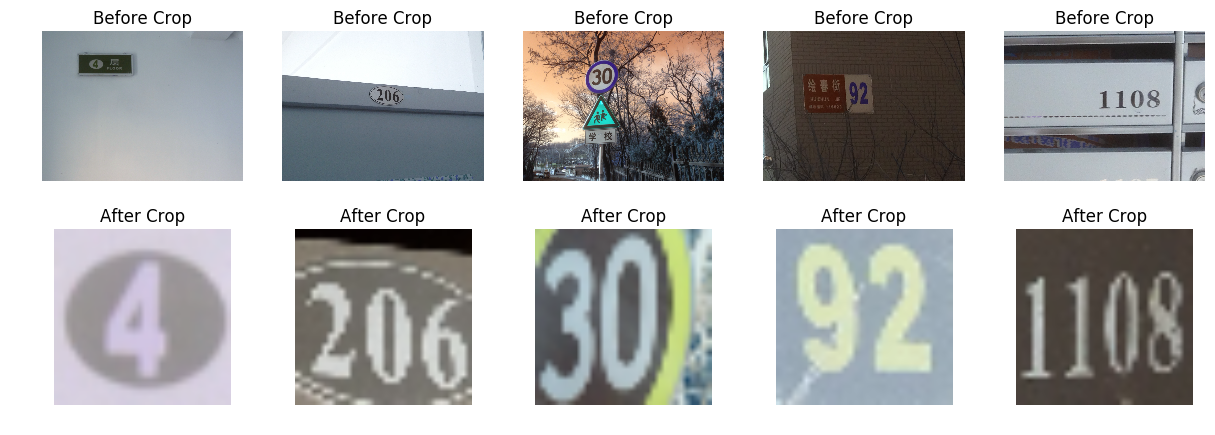

In [21]:
fig, axes = plt.subplots(nrows = 2, ncols = num_examples, figsize = (15, 5))
for i in xrange(num_examples):
    axes[0, i].axis('off')
    axes[0, i].imshow(cv2.imread(test_folder + file_names[i]))
    axes[0, i].set_title('Before Crop', loc='center')
    
    axes[1, i].axis('off')
    axes[1, i].imshow(real_dataset_cropped[i])
    axes[1, i].set_title('After Crop', loc='center')


report_folder = 'report/'
if not os.path.exists(report_folder):
    os.makedirs(report_folder)
fig.savefig(report_folder + 'real_image_cropped_manually.jpeg', format = 'jpeg', dpi = 300, bbox_inches = 'tight')

In [22]:
# Gray all the datasets
real_dataset_cropped_grayed = image_grayed(real_dataset_cropped)

In [23]:
model_path = 'model/'
dataset = real_dataset_cropped_grayed
predicted_labels = list()

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    saver.restore(session, model_path + 'CNN_SVHN')
    for i in xrange(num_examples):
        img = dataset[[i]]
        feed_dict = {tf_test_single: img}
        prediction_array = test_prediction_digits_single.eval(feed_dict = feed_dict)
        prediction_number = list()
        for j in xrange(len(prediction_array)):
            prediction_number.append(np.argmax(prediction_array[j]))
        predicted_labels.append(prediction_number)

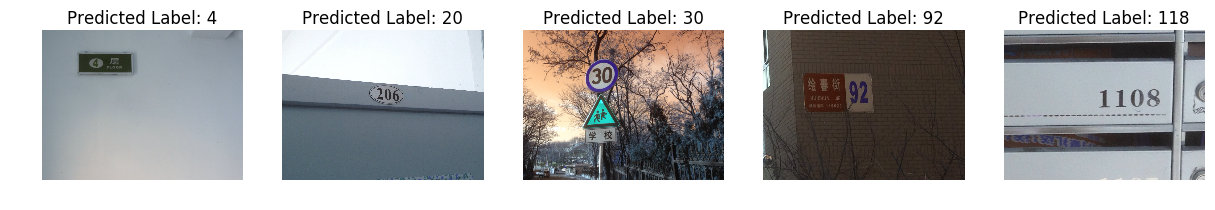

In [24]:
num_subplots = num_examples

fig, axes = plt.subplots(nrows = 1, ncols = num_examples, figsize = (15, 5))
for i in xrange(num_examples):
    axes[i].axis('off')
    axes[i].imshow(cv2.imread(test_folder + file_names[i]))
    axes[i].set_title('Predicted Label: ' + label_translation(predicted_labels[i]), loc='center')

report_folder = 'report/'
if not os.path.exists(report_folder):
    os.makedirs(report_folder)
fig.savefig(report_folder + 'real_image_prediction_manual_crop.jpeg', format = 'jpeg', dpi = 300, bbox_inches = 'tight')

It seems that manual crop helped to increase the prediction accuracy significantly. Therefore, it will be very helpful if I get develop an algorithm to determine the bounding box of digit sequence in the image. With this algorithm, I could crop the digit sequence from the raw image before I applied them into the digit recognizer.